In [1]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import torch
import math
import pandas as pd
import random
import wandb

import deepinv
from torchvision import datasets, transforms

from torch import nn, optim
from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR, SequentialLR
from torch.utils.data import DataLoader, Dataset, ConcatDataset

from datasets import load_dataset
from datetime import datetime
from tqdm import tqdm
import matplotlib.pyplot as plt

from models.UNet import UNet
from data.ImageDataset import ImageDataset

from pathlib import Path

/nfs/hpc/share/negreanj/miniforge/envs/torch_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# dynamically select device
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

In [ ]:
# model  = UNet(
#     in_channels=1,
#     out_channels=1,
#     channels=[64, 128, 256, 512, 512, 384, 256],
#     scales=[-1, -1, -1, 1, 1, 1, 0],
#     attentions=[False, True, False, False, False, True, False],
#     time_steps=1000
# ).to(device)

In [3]:
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.0,), (1.0,)),
])

dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(root="./data", train=True, download=True, transform=transform),
    batch_size=1,
    shuffle=True,
)

In [4]:
example = next(iter(dataloader))[0]

In [5]:
# load trained model
model_path = "/nfs/stak/users/negreanj/hpc-share/image-diffusion/checkpoints/diffusion-image-model/dim-2025_12_28_21_12/dim-2025_12_28_21_12_epoch99_end.pth"
chkpt = torch.load(model_path, weights_only=False, map_location=torch.device(device))

In [6]:
model = deepinv.models.DiffUNet(
    in_channels=1, out_channels=1, pretrained=None
).to(device)

model.load_state_dict(chkpt['model_state_dict'])
model.to(device)

DiffUNet(
  (time_embed): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): SiLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
  )
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): TimestepEmbedSequential(
      (0): ResBlock(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 128, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (h_upd): Identity()
        (x_upd): Identity()
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=512, out_features=256, bias=True)
        )
        (out_layers): Sequential(
          (0): GroupNorm32(32, 128, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Dropout(p=0.1, inplace=False)
          (3): Conv2d(128, 128, kernel_size=(3, 3), strid

In [7]:
# dry run
x = torch.randn(32, 1, 32, 32).to(device)
y = model(x, 100)
print(y.shape) # should be [32, 1, 32, 32]

torch.Size([32, 1, 32, 32])


In [8]:
# diffusion scheduler
beta = torch.linspace(1e-4, 0.02, 1000, requires_grad=False)
alpha = 1 - beta
alpha_hat = torch.cumprod(alpha, dim=0).requires_grad_(False)

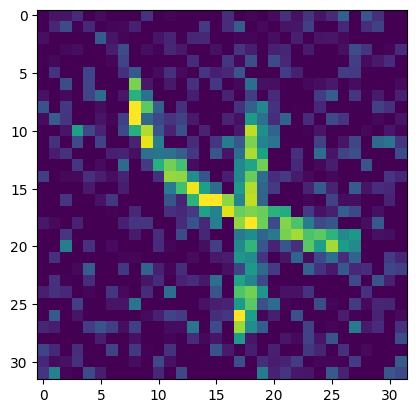

In [18]:
batch = example.to(device)
t = 50
noise = torch.randn(batch.size(), device=batch.device, dtype=batch.dtype).to(device)
diffuse_batch = math.sqrt(alpha_hat[t]) * batch + math.sqrt(1 - alpha_hat[t]) * noise
plt.imshow(diffuse_batch.squeeze(0).permute(1, 2, 0).cpu().numpy(), vmin=0, vmax=1)

In [19]:
pred_noise = model(diffuse_batch, t)
gen_image = (1 / torch.sqrt(alpha[t])) * (
            diffuse_batch - (beta[t] / torch.sqrt(1 - alpha_hat[t])) * pred_noise
        )
plt.imshow(gen_image.squeeze(0).permute(1, 2, 0).cpu().detach().numpy(), vmin=0, vmax=1)
print(gen_image - diffuse_batch)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/nfs/hpc/share/negreanj/miniforge/envs/torch_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3701, in run_code
  File "/tmp/ipykernel_2999456/2179294066.py", line 1, in <module>
  File "/nfs/hpc/share/negreanj/miniforge/envs/torch_env/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1775, in _wrapped_call_impl
  File "/nfs/hpc/share/negreanj/miniforge/envs/torch_env/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1786, in _call_impl
  File "/nfs/hpc/share/negreanj/miniforge/envs/torch_env/lib/python3.11/site-packages/deepinv/models/diffunet.py", line 325, in forward
  File "/nfs/hpc/share/negreanj/miniforge/envs/torch_env/lib/python3.11/site-packages/deepinv/models/diffunet.py", line 522, in forward_denoise
  File "/nfs/hpc/share/negreanj/miniforge/envs/torch_env/lib/python3.11/site-packages/deepinv/models/diffunet.py", line 445, in forward_diffusion
  File "/nfs/hpc/share/negreanj/miniforg

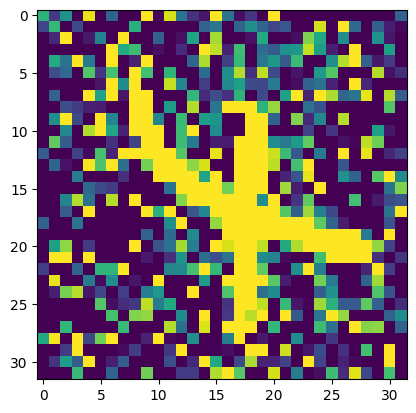

In [16]:
image = diffuse_batch - math.sqrt(1 - alpha_hat[t]) * model(diffuse_batch, t)
image /= math.sqrt(alpha_hat[t])
plt.imshow(image.squeeze(0).permute(1, 2, 0).cpu().detach().numpy(), vmin=0, vmax=1)

In [14]:
gen_image = torch.randn(batch.size(), device=batch.device, dtype=batch.dtype).to(device)

for i in range(100):
    t = 99 - i
    t *= 10

    gen_image = gen_image - math.sqrt(1 - alpha_hat[t]) * model(gen_image, t)
    gen_image /= math.sqrt(alpha_hat[t])
    gen_image += torch.randn(batch.size(), device=batch.device, dtype=batch.dtype).to(device) * math.sqrt(beta[t])

plt.imshow(image.squeeze(0).permute(1, 2, 0).cpu().detach().numpy(), vmin=0, vmax=1)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/nfs/hpc/share/negreanj/miniforge/envs/torch_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3701, in run_code
  File "/tmp/ipykernel_2999456/3110899200.py", line 7, in <module>
  File "/nfs/hpc/share/negreanj/miniforge/envs/torch_env/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1775, in _wrapped_call_impl
  File "/nfs/hpc/share/negreanj/miniforge/envs/torch_env/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1786, in _call_impl
  File "/nfs/hpc/share/negreanj/miniforge/envs/torch_env/lib/python3.11/site-packages/deepinv/models/diffunet.py", line 325, in forward
  File "/nfs/hpc/share/negreanj/miniforge/envs/torch_env/lib/python3.11/site-packages/deepinv/models/diffunet.py", line 522, in forward_denoise
  File "/nfs/hpc/share/negreanj/miniforge/envs/torch_env/lib/python3.11/site-packages/deepinv/models/diffunet.py", line 445, in forward_diffusion
  File "/nfs/hpc/share/negreanj/miniforg

In [15]:
plt.imshow(model(diffuse_batch, t).squeeze(0).permute(1, 2, 0).cpu().detach().numpy(), vmin=-1, vmax=1)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/nfs/hpc/share/negreanj/miniforge/envs/torch_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3701, in run_code
  File "/tmp/ipykernel_2999456/375519640.py", line 1, in <module>
  File "/nfs/hpc/share/negreanj/miniforge/envs/torch_env/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1775, in _wrapped_call_impl
  File "/nfs/hpc/share/negreanj/miniforge/envs/torch_env/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1786, in _call_impl
  File "/nfs/hpc/share/negreanj/miniforge/envs/torch_env/lib/python3.11/site-packages/deepinv/models/diffunet.py", line 325, in forward
  File "/nfs/hpc/share/negreanj/miniforge/envs/torch_env/lib/python3.11/site-packages/deepinv/models/diffunet.py", line 522, in forward_denoise
  File "/nfs/hpc/share/negreanj/miniforge/envs/torch_env/lib/python3.11/site-packages/deepinv/models/diffunet.py", line 440, in forward_diffusion
  File "/nfs/hpc/share/negreanj/miniforge

In [ ]:
train_config = {
    'max_examples': 1000,
    'max_len': 1000,
    'bs': 32,
    'lr': 0.0001,
    'weight_decay': 0.000001,
    'max_epochs': 10
}

In [ ]:
# optimizer and criterion
optimizer = optim.AdamW(model.parameters(), lr=train_config['lr'], weight_decay=train_config['weight_decay'])
criterion = nn.MSELoss()

# construct linear warmup and cosine annealing cooldown
warmup_epochs = int(train_config['max_epochs'] / 10)
cooldown_epochs = train_config['max_epochs'] - warmup_epochs
epoch_len = len(dataloader)

linear = LinearLR(optimizer, start_factor=0.25, end_factor=1.0, total_iters=warmup_epochs*epoch_len)
cosine = CosineAnnealingLR(optimizer, T_max=cooldown_epochs*epoch_len, eta_min=1e-6)
scheduler = SequentialLR(optimizer, schedulers=[linear, cosine], milestones=[warmup_epochs*epoch_len])

model.train()

# main training loop
pbar = tqdm(total=(train_config['max_epochs'])*epoch_len, desc="Training Iterations", unit="batch")
iteration = 0
for epoch in range(train_config['max_epochs']):
    # minibatch gradient descent
    for batch_idx, batch in enumerate(dataloader):
        # pick noising rate
        t = random.uniform(0.01, 0.99)

        # run batch through diffusion
        batch = batch.to(device)
        noise = torch.randn(batch.size(), device=x.device, dtype=x.dtype).to(device)
        diffuse_batch = math.sqrt(t) * batch + math.sqrt(1 - t) * noise

        # forward pass
        noise_pred = model(diffuse_batch)

        # compute L2 loss between predicted noise and true noise
        loss = criterion(noise_pred, noise)
        print(loss)

        # optimization
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        pbar.update(1)
        iteration += 1
        scheduler.step()


pbar.close()